In [1]:
import gzip
import json
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
import string
from sklearn import linear_model

In [2]:
f = gzip.open("renttherunway_final_data.json.gz")
dataset1 = []
for l in f:
    dataset1.append(json.loads(l))

FileNotFoundError: [Errno 2] No such file or directory: 'renttherunway_final_data.json.gz'

In [3]:
dataset1[1]

NameError: name 'dataset1' is not defined

In [4]:
len(dataset1)

192544

## Baseline Logistic Regression Model

Notes: Model does not use any user info or temporal characteristics

In [5]:
train = dataset1[:180000]
test = dataset1[180000:]

In [6]:
def accuracy(predictions, y):
    incorrect = np.sum(np.logical_xor(predictions, y))
    total = len(y)
    accuracy = (total - incorrect)/total
    return accuracy

In [7]:
def categorization_accuracy(prediction, y):
    ls = [prediction[i]==y[i] for i in range(len(y))]
    correct = np.sum(ls)
    total = len(y)
    cat_accuracy = correct / total
    return cat_accuracy

In [8]:
# useful data structures
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)

for d in train:
    u = d['user_id']
    i = d['item_id']
    reviewsPerUser[u].append(d)
    reviewsPerItem[i].append(d)

In [9]:
def features(u,i):
    fs = []
    fits = [d['fit'] for d in reviewsPerItem[i]]
    fs.append(len(fits))
    fs.append(fits.count('fit')/(len(fits)+0.1))
    fs.append(fits.count('small')/(len(fits)+0.1))
    fs.append(fits.count('large')/(len(fits)+0.1))
    return [1] + fs

In [10]:
X_train = [features(d['user_id'],d['item_id']) for d in train]
X_test = [features(d['user_id'],d['item_id']) for d in test]

In [11]:
y_train_fit = [d['fit']=="fit" for d in train]
y_test_fit = [d['fit']=="fit" for d in test]

y_train_small = [d['fit']=="small" for d in train]
y_test_small = [d['fit']=="small" for d in test]

y_train_large = [d['fit']=="large" for d in train]
y_test_large = [d['fit']=="large" for d in test]

In [12]:
mod_fit = linear_model.LogisticRegression(fit_intercept=False, max_iter=200, C=1)
mod_fit.fit(X_train,y_train_fit)
y_test_pred = mod_fit.predict(X_test)
print(accuracy(y_test_pred,y_test_fit))

0.7502391581632653


In [13]:
mod_small = linear_model.LogisticRegression(fit_intercept=False, max_iter=200, C=1)
mod_small.fit(X_train,y_train_small)
y_test_pred = mod_small.predict(X_test)
print(accuracy(y_test_pred,y_test_small))

0.8696588010204082


In [14]:
mod_large = linear_model.LogisticRegression(fit_intercept=False, max_iter=200, C=1)
mod_large.fit(X_train,y_train_large)
y_test_pred = mod_large.predict(X_test)
print(accuracy(y_test_pred,y_test_large))

0.8783482142857143


In [15]:
def class_prediction(X):
    fit_percent = mod_fit.predict_proba(X)
    small_percent = mod_small.predict_proba(X)
    large_percent = mod_large.predict_proba(X)
    
    percents = list(zip(fit_percent[:,1],small_percent[:,1],large_percent[:,1]))
    preds = []
    for i in range(len(X)):
        f,s,l = percents[i]
        #print(f,s,l)
        if l > s and l > f:
            preds.append('large')
        elif s > f and s > l:
            preds.append('small')
        else:
            preds.append('fit')
    return preds

In [16]:
y = [d['fit'] for d in test]
preds = class_prediction(X_test)
print("Categorization Accuracy of Model: ", categorization_accuracy(preds, y))

Categorization Accuracy of Model:  0.75


In [17]:
# multi class logistic regression using library (one vs rest)
y_train = [d['fit'] for d in train]
y_test = [d['fit'] for d in test]

mod = linear_model.LogisticRegression(fit_intercept=False, max_iter=200, C=1, multi_class='ovr')
mod.fit(X_train,y_train)
y_test_pred = mod.predict(X_test)
print(categorization_accuracy(y_test_pred,y_test))

0.75


In [18]:
import sklearn
sklearn.metrics.roc_auc_score(y_test, mod.predict_proba(X_test), multi_class='ovr')

0.7371842596778294

In [19]:
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output
y_test = [d['fit'] for d in test]
y_train = [d['fit'] for d in train]

n_classes = 3

X_train = [features(d['user_id'],d['item_id']) for d in train]
X_test = [features(d['user_id'],d['item_id']) for d in test]

In [20]:
mod = linear_model.LogisticRegression(fit_intercept=False, max_iter=200, C=1, multi_class='ovr')
mod.fit(X_train,y_train)
y_score = mod.decision_function(X_test)

In [21]:
mod.classes_

array(['fit', 'large', 'small'], dtype='<U5')

In [22]:
y_testb = label_binarize(y_test, classes=['fit', 'large', 'small'])
y_trainb = label_binarize(y_train, classes=['fit', 'large', 'small'])

In [23]:
y_score

array([[ 1.2359309 , -2.68996017, -1.96971428],
       [ 0.9873461 , -1.01373088, -3.46633572],
       [ 1.57430371, -3.08749097, -1.86983233],
       ...,
       [ 1.07836257, -3.41416113, -1.22970374],
       [ 1.10626239, -1.44526476, -2.80443176],
       [ 2.01026295, -2.64743212, -2.37509138]])

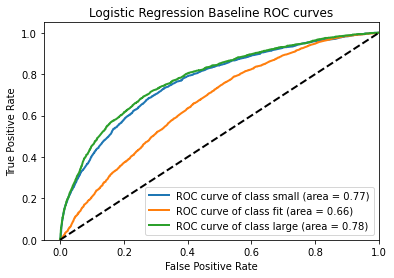

In [24]:
fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_testb[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
for i in [2,0,1]:
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(mod.classes_[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Baseline ROC curves')
plt.legend(loc="lower right")
plt.show()

In [25]:
0.73*(0.66)+0.12*(0.78)+0.13*(0.77)

0.6755